In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import yfinance as yf
from matplotlib.patches import Patch

plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 5)
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['lines.linewidth'] = 1.5

np.random.seed(13)

print("[OK]")

[OK]


# **Bloque II — Fundamentos Cuantitativos**
---
## **3.5 Activos como Vectores y Portfolios**
### *Diversificación Matemática y Dimensionalidad*

**Objetivo de la clase:** Entender los activos financieros como **vectores aleatorios**, las carteras como **combinaciones lineales**, y la diversificación como un fenómeno **geométrico**. Introduciremos la **matriz de covarianzas**, los **factores de mercado** mediante PCA como cambio de base, y demostraremos por qué la optimización clásica de carteras tiene limitaciones fundamentales.

**Estructura:**
1. **Activos como Vectores**: Cada activo es un vector en $\mathbb{R}^n$; sus retornos son coordenadas en el espacio de los estados.
2. **Matriz de Covarianzas**: La estructura de dependencia entre activos y por qué importa.
3. **Portfolios como Combinaciones Lineales**: Una cartera es $r_p = \mathbf{w}^T \mathbf{r}$, interpretación geométrica.
4. **Diversificación Real**: Reducción de varianza a través de la geometría, no simplemente "tener muchos activos".
5. **PCA como Cambio de Base**: Diagonalizar la covarianza: de activos correlacionados a factores ortogonales.
6. **De Muchas Acciones a Pocos Factores**: Cómo 20+ acciones se resumen en 2-3 vectores principales.
7. **No-Estacionariedad de los Factores**: La base cambia en el tiempo, la covarianza es inestable.

## Activos como Vectores en $\mathbb{R}^n$

En los notebooks anteriores tratamos cada activo como una **variable aleatoria escalar**: un número $r_t$ por cada día. Pero cuando tenemos $p$ activos observados durante $n$ días, lo natural es pensar en ellos como **vectores**.

Cada activo $i$ es un vector en $\mathbb{R}^n$:

$$
\mathbf{r}_i = \begin{pmatrix} r_{i,1} \\ r_{i,2} \\ \vdots \\ r_{i,n} \end{pmatrix} \in \mathbb{R}^n
$$

donde $r_{i,t}$ es el log-retorno del activo $i$ en el día $t$.

Si tenemos $p$ activos, la **matriz de retornos** $X$ es una matriz $n \times p$:

$$
X = \begin{pmatrix} \mathbf{r}_1 & \mathbf{r}_2 & \cdots & \mathbf{r}_p \end{pmatrix} = \begin{pmatrix} r_{1,1} & r_{2,1} & \cdots & r_{p,1} \\ r_{1,2} & r_{2,2} & \cdots & r_{p,2} \\ \vdots & \vdots & \ddots & \vdots \\ r_{1,n} & r_{2,n} & \cdots & r_{p,n} \end{pmatrix}
$$

Cada **columna** es un activo (un vector en $\mathbb{R}^n$). Cada **fila** es un día de mercado, entonces asi queda un snapshot del mercado entero.

**¿Por qué importa esto?** Porque las relaciones entre activos (correlación, diversificación, riesgo) se convierten en **operaciones geométricas**: ángulos entre vectores, proyecciones, rotaciones de base...

In [35]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA',  # tecnologia
    'JPM', 'GS', 'BAC',# finance
    'JNJ', 'PFE', 'UNH',# salud
    'XOM', 'CVX',# energia
    'PG', 'KO', 'WMT',# consumo
    'CAT', 'BA',# industria
    'NEE', 'DUK'# utils
]

data = yf.download(tickers, start='2021-01-01', end='2023-01-01', auto_adjust=True)['Close']
data = data.dropna()

log_returns = np.log(data / data.shift(1)).dropna()

print(f"Matriz de retornos X: {log_returns.shape[0]} días × {log_returns.shape[1]} activos")
print(f"Activos: {list(log_returns.columns)}")
log_returns.head()

[*********************100%***********************]  20 of 20 completed

Matriz de retornos X: 502 días × 20 activos
Activos: ['AAPL', 'AMZN', 'BA', 'BAC', 'CAT', 'CVX', 'DUK', 'GOOGL', 'GS', 'JNJ', 'JPM', 'KO', 'MSFT', 'NEE', 'NVDA', 'PFE', 'PG', 'UNH', 'WMT', 'XOM']


Ticker,AAPL,AMZN,BA,BAC,CAT,CVX,DUK,GOOGL,GS,JNJ,JPM,KO,MSFT,NEE,NVDA,PFE,PG,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,
2021-01-05,0.012288,0.009955,0.043014,0.007630,0.008147,0.026675,0.000446,0.008032,0.022131,0.011689,0.005427,-0.011054,0.000964,0.007383,0.021967,0.010271,0.006365,-0.013539,-0.005337,0.047068
2021-01-06,-0.034241,-0.025212,-0.002839,0.060586,0.054159,0.031677,0.012842,-0.009917,0.052557,0.009366,0.045887,-0.032330,-0.026271,0.047790,-0.060762,-0.008642,0.010471,0.041110,0.006224,0.025197
2021-01-07,0.033554,0.007549,0.007929,0.021844,0.001907,0.004666,-0.011283,0.029431,0.021138,0.003373,0.032311,-0.011147,0.028059,0.010905,0.056220,0.005140,-0.009390,0.015905,-0.000068,0.007815
2021-01-08,0.008594,0.006475,-0.013299,-0.010093,0.000155,0.009487,0.001778,0.013152,-0.005398,-0.002060,0.001104,0.022170,0.006074,0.022941,-0.005052,0.001887,-0.000432,-0.004503,-0.000136,0.011060
2021-01-11,-0.023523,-0.021754,-0.014927,0.016464,-0.002061,0.005693,-0.008476,-0.023377,0.012845,-0.004195,0.014814,-0.017378,-0.009746,-0.017909,0.025635,0.017090,-0.006796,-0.007292,0.004491,0.029904


Cada activo es un vector en $\mathbb{R}^{502}$

**¿Qué significa esto?**

Si $n = 2$, es una lista de 2 números (como coordenadas en un mapa plano: $x, y$).

Si $n = 3$, es una lista de 3 números (como el espacio físico 3D: $x, y, z$).

Si $n = 502$, es simplemente una lista de 502 números.

No intentes visualizar un espacio físico con 502 direcciones; piensa simplemente en una **columna de datos con 502 filas**, porque cada fila es un día para ese activo.

## La Matriz de Covarianzas $\Sigma$

La **matriz de covarianzas** $\Sigma$ captura toda la estructura de dependencia lineal entre los $p$ activos:

$$
\Sigma = \frac{1}{n-1} X^T X \quad \in \mathbb{R}^{p \times p}
$$

donde $X$ es la matriz de retornos **centrada** (media cero por columna).

### De Escalar a Matricial

Recordemos la covarianza clásica entre dos activos $x$ e $y$

$$
\text{Cov}(x, y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$

**Detalle crucial:** $X$ es la matriz **centrada**. Esto significa que a cada dato ya se le restó la media ($\bar{x}$). Por tanto, la parte de $(x_i - \bar{x})$ ya está hecha dentro de $X$.

| Concepto | Estadística Básica (Escalar) | Álgebra Lineal (Matricial) |
|----------|------------------------------|----------------------------|
| La Suma | $\sum (x_i)(y_i)$ | $X^T X$ |
| El Promedio | Dividir por $n-1$ | Multiplicar por $\frac{1}{n-1}$ |
| El Resultado | Un número (covarianza) | Una matriz $\Sigma$ (todas las covarianzas) |

**La covarianza entre dos vectores es proporcional al **coseno del ángulo** entre ellos. Activos con correlación alta apuntan en direcciones similares en $\mathbb{R}^n$.**

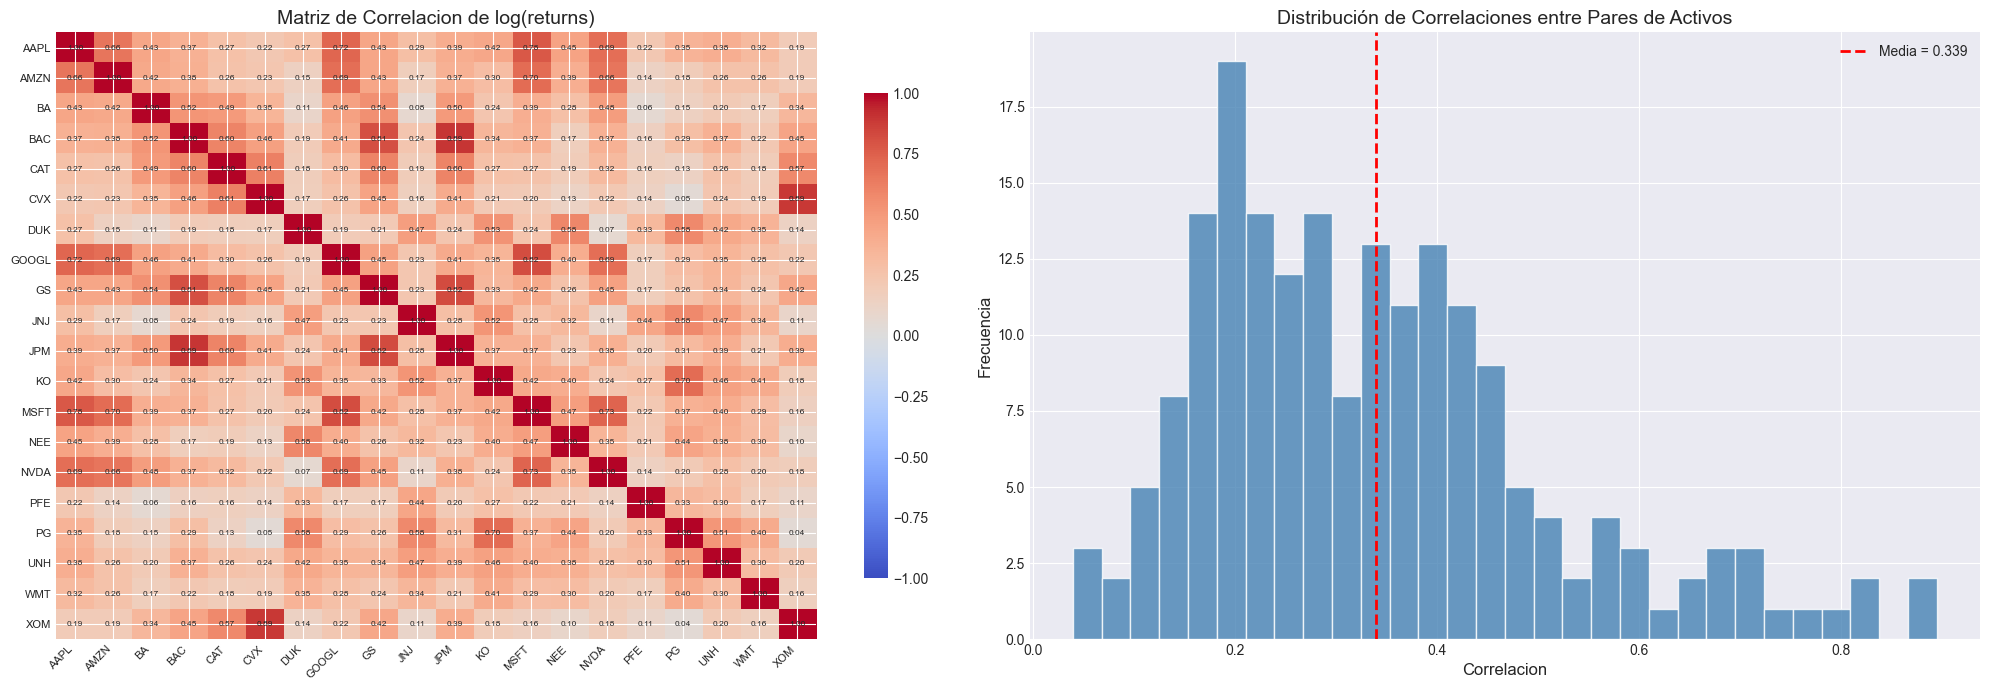

Correlacion media entre todos los pares: 0.339
Correlacion mínima: 0.039
Correlacion máxima: 0.895


In [36]:
correlation_matrix = log_returns.corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# corr matrix
im = axes[0].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im, ax=axes[0], shrink=0.8)
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        axes[0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', fontsize=6)
axes[0].set_xticks(range(len(correlation_matrix)))
axes[0].set_xticklabels(correlation_matrix.columns, rotation=45, ha='right', fontsize=8)
axes[0].set_yticks(range(len(correlation_matrix)))
axes[0].set_yticklabels(correlation_matrix.columns, fontsize=8)
axes[0].set_title('Matriz de Correlacion de log(returns)')

#distribvucion correlaciones sin diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
upper_corrs = correlation_matrix.where(mask).stack().values
axes[1].hist(upper_corrs, bins=30, color='steelblue', edgecolor='white', alpha=0.8)
axes[1].axvline(x=np.mean(upper_corrs), color='red', linestyle='--', linewidth=2,label=f'Media = {np.mean(upper_corrs):.3f}')
axes[1].set_xlabel('Correlacion')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Correlaciones entre Pares de Activos')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Correlacion media entre todos los pares: {np.mean(upper_corrs):.3f}")
print(f"Correlacion mínima: {np.min(upper_corrs):.3f}")
print(f"Correlacion máxima: {np.max(upper_corrs):.3f}")

La mayoría de acciones están **positivamente correlacionadas**. Esto tiene sentido: cuando el mercado sube, la mayoría de acciones suben también. Pero esta alta correlación es un problema serio:

1. **Redundancia informativa:** Si AAPL y MSFT tienen correlación 0.80, contienen mayoritariamente la misma información. Tener ambas en tu modelo es casi como duplicar la misma feature.
2. **Multicolinealidad:** En regresión, los coeficientes se vuelven inestables.
3. **Diversificación ilusoria:** Tener 20 acciones correlacionadas no es muy diferente de tener 3 o 4.

Esto nos lleva a la pregunta central: **¿cuántas dimensiones *reales* tiene este mercado?**

## Portfolios como Combinaciones Lineales

Un **portfolio** no es más que una **combinación lineal** de los vectores de retorno de cada activo. Si asignamos pesos $w_1, w_2, \dots, w_p$ a cada activo (con $\sum w_i = 1$), el retorno del portfolio en el día $t$ es:

$$
r_{p,t} = w_1 r_{1,t} + w_2 r_{2,t} + \cdots + w_p r_{p,t} = \mathbf{w}^T \mathbf{r}_t
$$

El vector de retornos del portfolio completo es:

$$
\mathbf{r}_p = X \mathbf{w} \in \mathbb{R}^n
$$

**Geométricamente**, el portfolio es un vector en el mismo espacio $\mathbb{R}^n$ que cada activo individual, pero "apuntando" en una dirección que es una mezcla ponderada de las direcciones de cada activo.

Las propiedades del portfolio se derivan directamente del álgebra lineal:

$$
\mathbb{E}[r_p] = \mathbf{w}^T \boldsymbol{\mu}
$$

$$
\text{Var}(r_p) = \mathbf{w}^T \Sigma \, \mathbf{w}
$$

donde $\boldsymbol{\mu}$ es el vector de retornos esperados y $\Sigma$ la matriz de covarianzas.

> La varianza del portfolio **no** es simplemente el promedio ponderado de las varianzas individuales. Los términos cruzados $w_i w_j \sigma_{ij}$ (covarianza) son fundamentales, y es exactamente ahí donde vive la diversificación.

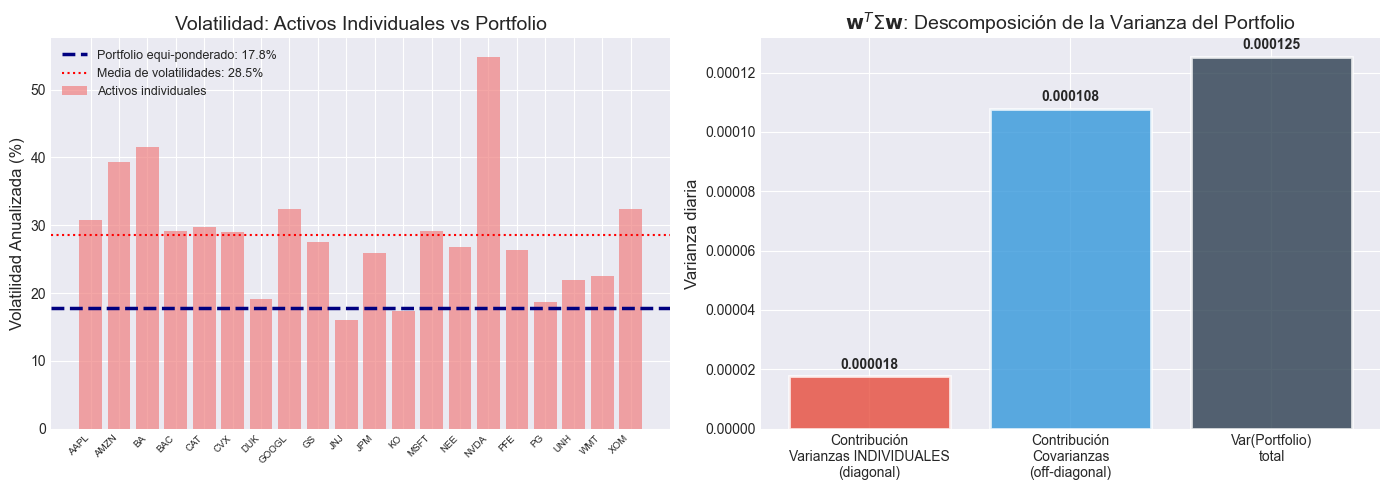

Volatilidad del portfolio equi-ponderado: 17.77% anual
Promedio de volatilidades individuales: 28.51% anual
Reducción por diversificación (total): 37.7%


In [41]:
# Demostracion: Portfolio equiponderado vs activos individuales
n_assets = log_returns.shape[1]
equal_weights = np.ones(n_assets) / n_assets

# retorno del portfolio equiponderado
portfolio_returns = log_returns.values @ equal_weights

# comparar varianza de portfolio equiponderado vs promedio de varianzas individuales
var_portfolio = np.var(portfolio_returns)
avg_var_individual = np.mean(np.var(log_returns.values, axis=0))
cov_matrix = np.cov(log_returns.values.T)

# descomponer la varianza del portfolio
diagonal_contribution = np.sum(np.diag(cov_matrix)) / n_assets**2
offdiag_contribution = (np.sum(cov_matrix) - np.sum(np.diag(cov_matrix))) / n_assets**2

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

individual_vols = np.std(log_returns.values, axis=0) * np.sqrt(252) * 100
portfolio_vol = np.std(portfolio_returns) * np.sqrt(252) * 100

axes[0].bar(range(n_assets), individual_vols, color='lightcoral', alpha=0.7, label='Activos individuales')
axes[0].axhline(y=portfolio_vol, color='navy', linewidth=2.5, linestyle='--',label=f'Portfolio equi-ponderado: {portfolio_vol:.1f}%')
axes[0].axhline(y=np.mean(individual_vols), color='red', linewidth=1.5, linestyle=':',label=f'Media de volatilidades: {np.mean(individual_vols):.1f}%')
axes[0].set_xticks(range(n_assets))
axes[0].set_xticklabels(log_returns.columns, rotation=45, ha='right', fontsize=7)
axes[0].set_ylabel('Volatilidad Anualizada (%)')
axes[0].set_title('Volatilidad: Activos Individuales vs Portfolio')
axes[0].legend(fontsize=9)

labels = ['Contribución\nVarianzas INDIVIDUALES\n(diagonal)', 'Contribución\nCovarianzas\n(off-diagonal)', 'Var(Portfolio)\ntotal']
values = [diagonal_contribution, offdiag_contribution, var_portfolio]
colors = ['#e74c3c', '#3498db', '#2c3e50']
axes[1].bar(labels, values, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
axes[1].set_ylabel('Varianza diaria')
axes[1].set_title(r'$\mathbf{w}^T \Sigma \mathbf{w}$: Descomposición de la Varianza del Portfolio')

for i, v in enumerate(values):
    axes[1].text(i, v + max(values)*0.02, f'{v:.6f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Volatilidad del portfolio equi-ponderado: {portfolio_vol:.2f}% anual")
print(f"Promedio de volatilidades individuales: {np.mean(individual_vols):.2f}% anual")
print(f"Reducción por diversificación (total): {(1 - portfolio_vol/np.mean(individual_vols))*100:.1f}%")

En un portfolio bien diversificado, el riesgo total es casi exclusivamente el promedio de las covarianzas.

En este portfolio hay solo 20 varianzas, pero hay 380(lo azul claro) relaciones entre pares. Por eso, en un portfolio grande, lo único que importa es cómo interactúan los activos entre sí, no cómo se comportan solos.

## Diversificación Real

La fórmula de la varianza del portfolio para $p$ activos con pesos iguales ($w_i = 1/p$) nos revela la mecánica de la diversificación:

$$
\text{Var}(r_p) = \frac{1}{p^2} \sum_{i=1}^{p} \sigma_i^2 + \frac{1}{p^2} \sum_{i \neq j} \sigma_{ij}
$$

A medida que $p \to \infty$:
- El primer término (varianzas individuales) → $0$ como $O(1/p)$
- El segundo término (covarianzas) → $\bar{\sigma}_{ij}$ (la **covarianza media**)

$$
\lim_{p \to \infty} \text{Var}(r_p) = \bar{\sigma}_{ij}
$$

**Esto es la diversificación real:** podemos eliminar el riesgo específico de cada activo, pero NO el riesgo **sistemático** (la covarianza media del mercado). No importa cuántas acciones añadamos: si todas se mueven juntas cuando el mercado cae, la diversificación tiene un límite.

Geométricamente, si todos los vectores de retorno apuntan más o menos en la misma dirección, ninguna combinación lineal puede escapar de ese subespacio.

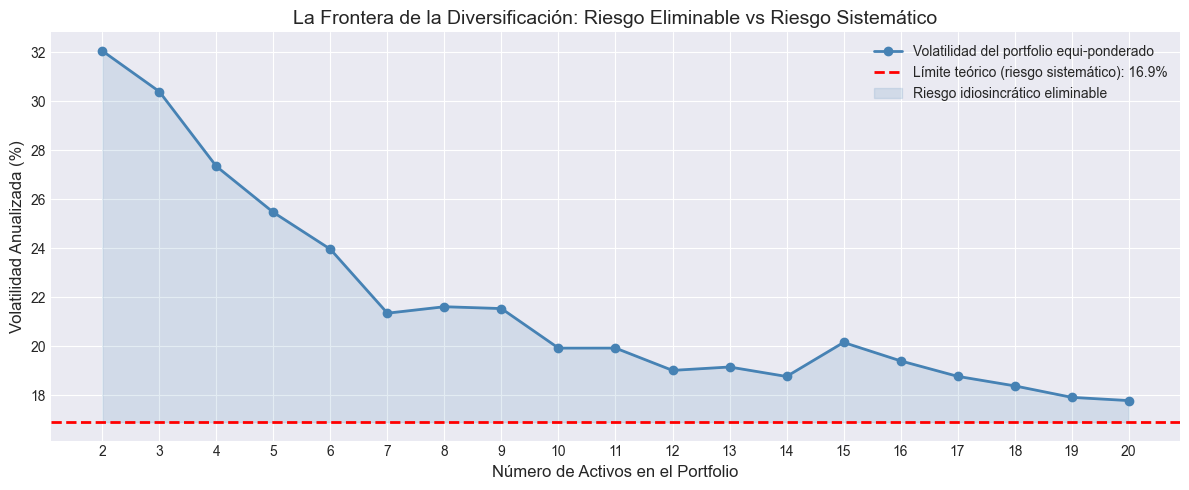

Riesgo con 2 activos:  32.05%
Riesgo con 20 activos: 17.79%
Límite teórico:        16.92%


In [40]:
# demostracion: diversificación vs número de activos
# simular la varianza del portfolio equiponderado aumentando p
cov_full = np.cov(log_returns.values.T)
tickers_list = list(log_returns.columns)

portfolio_vols = []
n_assets_range = range(2, n_assets + 1)

for p in n_assets_range:
    # cogemos los primeros p activos
    w = np.ones(p) / p
    cov_sub = cov_full[:p, :p]
    var_p = w @ cov_sub @ w
    portfolio_vols.append(np.sqrt(var_p) * np.sqrt(252) * 100)

# calculamos límite teórico que seria covarianza media
avg_cov = (np.sum(cov_full) - np.sum(np.diag(cov_full))) / (n_assets * (n_assets - 1))
limit_vol = np.sqrt(avg_cov) * np.sqrt(252) * 100

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(list(n_assets_range), portfolio_vols, 'o-', color='steelblue', linewidth=2, markersize=6,label='Volatilidad del portfolio equi-ponderado')
ax.axhline(y=limit_vol, color='red', linestyle='--', linewidth=2,label=f'Límite teórico (riesgo sistemático): {limit_vol:.1f}%')
ax.fill_between(list(n_assets_range), limit_vol, portfolio_vols, alpha=0.15, color='steelblue',label='Riesgo idiosincrático eliminable')

ax.set_xlabel('Número de Activos en el Portfolio')
ax.set_ylabel('Volatilidad Anualizada (%)')
ax.set_title('La Frontera de la Diversificación: Riesgo Eliminable vs Riesgo Sistemático')
ax.legend()
ax.set_xticks(list(n_assets_range))
plt.tight_layout()
plt.show()

print(f"Riesgo con 2 activos:  {portfolio_vols[0]:.2f}%")
print(f"Riesgo con {n_assets} activos: {portfolio_vols[-1]:.2f}%")
print(f"Límite teórico:        {limit_vol:.2f}%")

No importa cuántos activos añadas: nunca bajarás de x% porque la covarianza media es positiva.

## PCA como Cambio de Base: De Activos a Factores

El problema de la matriz de correlación es claro: está llena de números fuera de la diagonal. La información está **redundante y entrelazada**. 

**PCA (Análisis de Componentes Principales)** resuelve esto encontrando una nueva base (una rotación del espacio) donde la covarianza es **diagonal**. Es decir, buscamos vectores ortogonales que capturen la máxima varianza posible.

### Formulación Matemática

Dada la matriz de covarianzas $\Sigma$, buscamos su **eigendescomposición**:

$$
\Sigma = V \Lambda V^T
$$

donde:
- $V$ contiene los **eigenvectores** (las direcciones de los componentes principales)
- $\Lambda$ es **diagonal** con los **eigenvalores** $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_p$

Si transformamos los datos multiplicando por $V$:

$$
Z = X V
$$

entonces la covarianza de $Z$ es:

$$
\text{Cov}(Z) = V^T \Sigma V = V^T (V \Lambda V^T) V = \Lambda
$$

**¡Diagonal!** Los componentes principales son **ortogonales** (correlación cero entre sí).

### Equivalencia con SVD (Singular Value Decomposition)

La misma transformación se obtiene via SVD de $X = U \Sigma_s V^T$, donde:
- Los eigenvectores de $\Sigma$ son los vectores singulares derechos ($V$)
- Los eigenvalores satisfacen $\lambda_i = \sigma_i^2 / (n-1)$

### ¿Qué significa esto en finanzas?

Cada **componente principal** es un "factor de mercado" sintético:
- **PC1** típicamente es el **factor de mercado** (todas las acciones moviéndose juntas)
- **PC2** suele capturar una rotación **sectorial** (e.g tech vs energía)
- **PC3** y siguientes pueden capturan dinámicas más específicas

Estamos pasando de una base de $p$ activos correlacionados a una base de $p$ factores **independientes**.

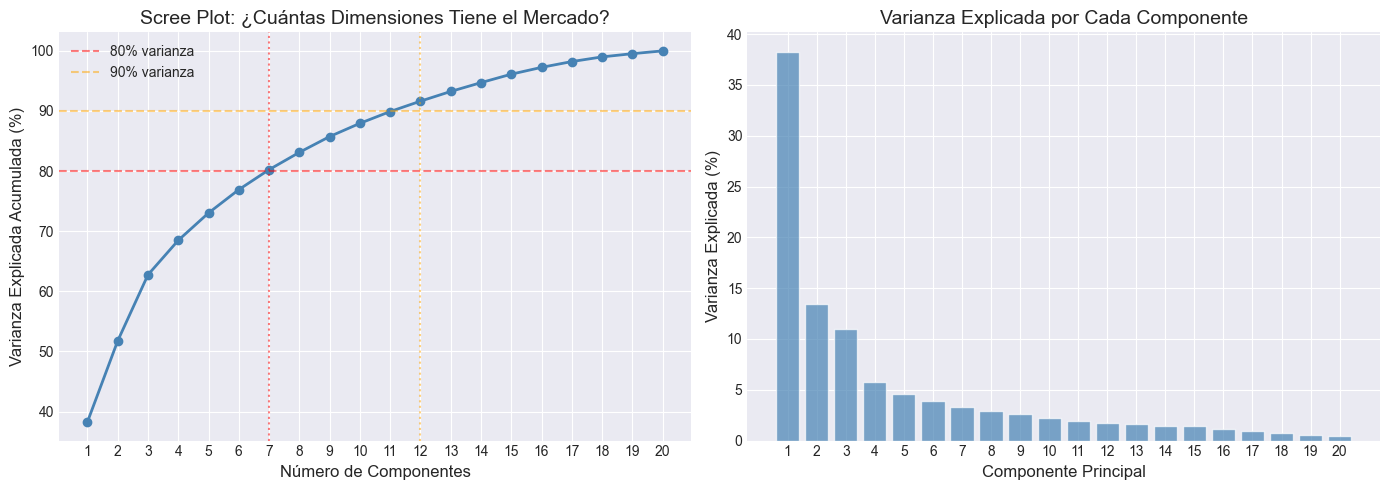

PC1 explica: 38.3% de la varianza total
PC1 + PC2:   51.8%
PC1-PC3:     62.7%

→ Con solo 7 componentes capturamos el 80% de la varianza de 20 acciones.
→ Con 12 componentes capturamos el 90%.

¡20 acciones se pueden resumir en ~7 factores principales!


In [42]:
# aplicar PCA a los retornos std
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(log_returns)

pca = PCA()
pca_result = pca.fit_transform(returns_scaled)

# dimensiones reales mercado?
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, n_assets + 1), np.cumsum(pca.explained_variance_ratio_) * 100,'o-', color='steelblue', linewidth=2, markersize=6)
axes[0].axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80% varianza')
axes[0].axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='90% varianza')

n_80 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.80) + 1
n_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
axes[0].axvline(x=n_80, color='red', linestyle=':', alpha=0.5)
axes[0].axvline(x=n_90, color='orange', linestyle=':', alpha=0.5)

axes[0].set_xlabel('Número de Componentes')
axes[0].set_ylabel('Varianza Explicada Acumulada (%)')
axes[0].set_title('Scree Plot: ¿Cuántas Dimensiones Tiene el Mercado?')
axes[0].legend()
axes[0].set_xticks(range(1, n_assets + 1))

axes[1].bar(range(1, n_assets + 1), pca.explained_variance_ratio_ * 100,
            color='steelblue', alpha=0.7, edgecolor='white')
axes[1].set_xlabel('Componente Principal')
axes[1].set_ylabel('Varianza Explicada (%)')
axes[1].set_title('Varianza Explicada por Cada Componente')
axes[1].set_xticks(range(1, n_assets + 1))

plt.tight_layout()
plt.show()

print(f"PC1 explica: {pca.explained_variance_ratio_[0]*100:.1f}% de la varianza total")
print(f"PC1 + PC2:   {sum(pca.explained_variance_ratio_[:2])*100:.1f}%")
print(f"PC1-PC3:     {sum(pca.explained_variance_ratio_[:3])*100:.1f}%")
print(f"\n→ Con solo {n_80} componentes capturamos el 80% de la varianza de {n_assets} acciones.")
print(f"→ Con {n_90} componentes capturamos el 90%.")
print(f"\n¡{n_assets} acciones se pueden resumir en ~{n_80} factores principales!")

## ¿Qué Captura Cada Componente?

Los **loadings** o pesos de cada componente principal nos dicen cómo se construye cada factor a partir de los activos originales. El loading $v_{ij}$ indica cuánto contribuye el activo $j$ al componente $i$.

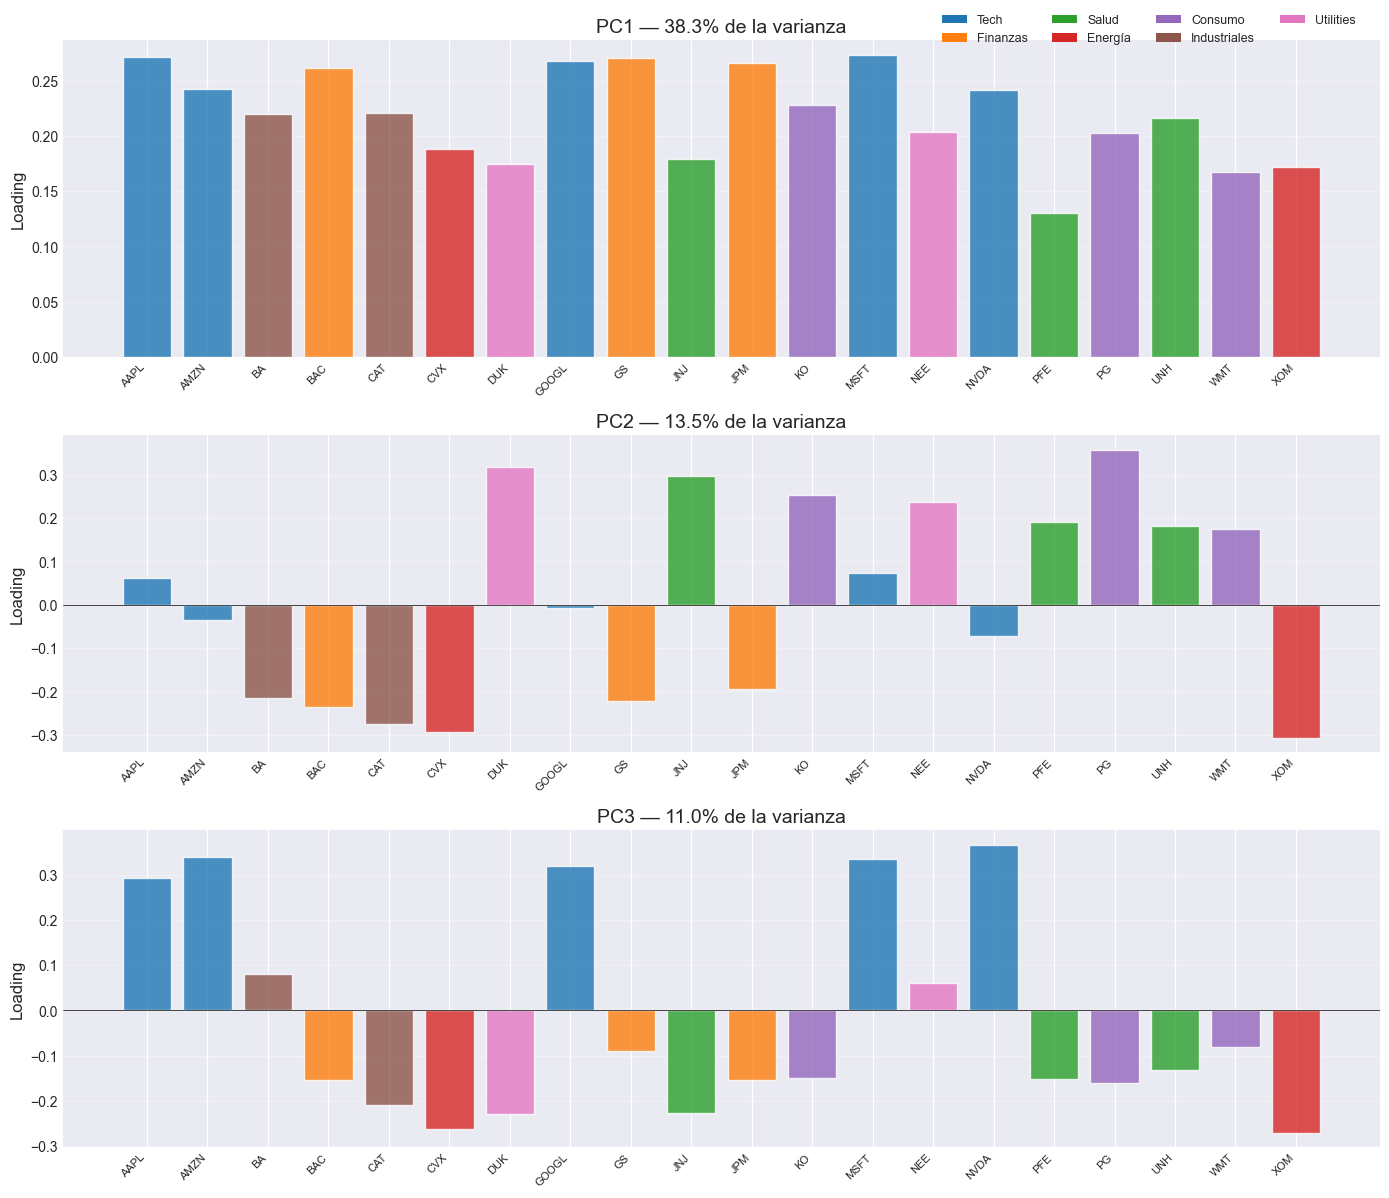

Interpretación de los Componentes Principales:

PC1 (38.3% varianza):
  → Factor de MERCADO: todos los loadings son positivos y similares.
    Cuando PC1 sube, TODO el mercado sube.

PC2 (13.5% varianza):
  → Mayores loadings positivos: PG (0.358), DUK (0.318), JNJ (0.298)
  → Mayores loadings negativos: XOM (-0.307), CVX (-0.294), CAT (-0.275)

PC3 (11.0% varianza):
  → Mayores loadings positivos: NVDA (0.366), AMZN (0.339), MSFT (0.335)
  → Mayores loadings negativos: XOM (-0.271), CVX (-0.263), DUK (-0.230)


In [22]:
# Visualizar los loadings de los 3 primeros pc
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_assets)],
    index=log_returns.columns
)

sector_colors = {
    'AAPL': '#1f77b4', 'MSFT': '#1f77b4', 'GOOGL': '#1f77b4', 'AMZN': '#1f77b4', 'NVDA': '#1f77b4',  # Tech
    'JPM': '#ff7f0e', 'GS': '#ff7f0e', 'BAC': '#ff7f0e',   # Finanzas
    'JNJ': '#2ca02c', 'PFE': '#2ca02c', 'UNH': '#2ca02c',   # Salud
    'XOM': '#d62728', 'CVX': '#d62728',                       # Energía
    'PG': '#9467bd', 'KO': '#9467bd', 'WMT': '#9467bd',      # Consumo
    'CAT': '#8c564b', 'BA': '#8c564b',                        # Industriales
    'NEE': '#e377c2', 'DUK': '#e377c2'                        # Utilities
}
colors = [sector_colors.get(t, 'gray') for t in log_returns.columns]

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for i in range(3):
    bars = axes[i].bar(range(n_assets), loadings[f'PC{i+1}'], color=colors, alpha=0.8, edgecolor='white')
    axes[i].set_xticks(range(n_assets))
    axes[i].set_xticklabels(log_returns.columns, rotation=45, ha='right', fontsize=8)
    axes[i].set_ylabel('Loading')
    axes[i].set_title(f'PC{i+1} — {pca.explained_variance_ratio_[i]*100:.1f}% de la varianza')
    axes[i].axhline(y=0, color='black', linewidth=0.5)
    axes[i].grid(axis='y', alpha=0.3)


legend_elements = [
    Patch(facecolor='#1f77b4', label='Tech'),
    Patch(facecolor='#ff7f0e', label='Finanzas'),
    Patch(facecolor='#2ca02c', label='Salud'),
    Patch(facecolor='#d62728', label='Energía'),
    Patch(facecolor='#9467bd', label='Consumo'),
    Patch(facecolor='#8c564b', label='Industriales'),
    Patch(facecolor='#e377c2', label='Utilities'),
]
fig.legend(handles=legend_elements, loc='upper right', ncol=4, fontsize=9, bbox_to_anchor=(0.98, 1.0))

plt.tight_layout()
plt.show()

print("Interpretación de los Componentes Principales:")
for i in range(3):
    pc = loadings[f'PC{i+1}']
    top_pos = pc.nlargest(3)
    top_neg = pc.nsmallest(3)
    print(f"\nPC{i+1} ({pca.explained_variance_ratio_[i]*100:.1f}% varianza):")
    
    if np.std(pc) < 0.1 and all(pc > 0):
        print(f"  → Factor de MERCADO: todos los loadings son positivos y similares.")
        print(f"    Cuando PC1 sube, TODO el mercado sube.")
    else:
        print(f"  → Mayores loadings positivos: {', '.join([f'{k} ({v:.3f})' for k, v in top_pos.items()])}")
        print(f"  → Mayores loadings negativos: {', '.join([f'{k} ({v:.3f})' for k, v in top_neg.items()])}")

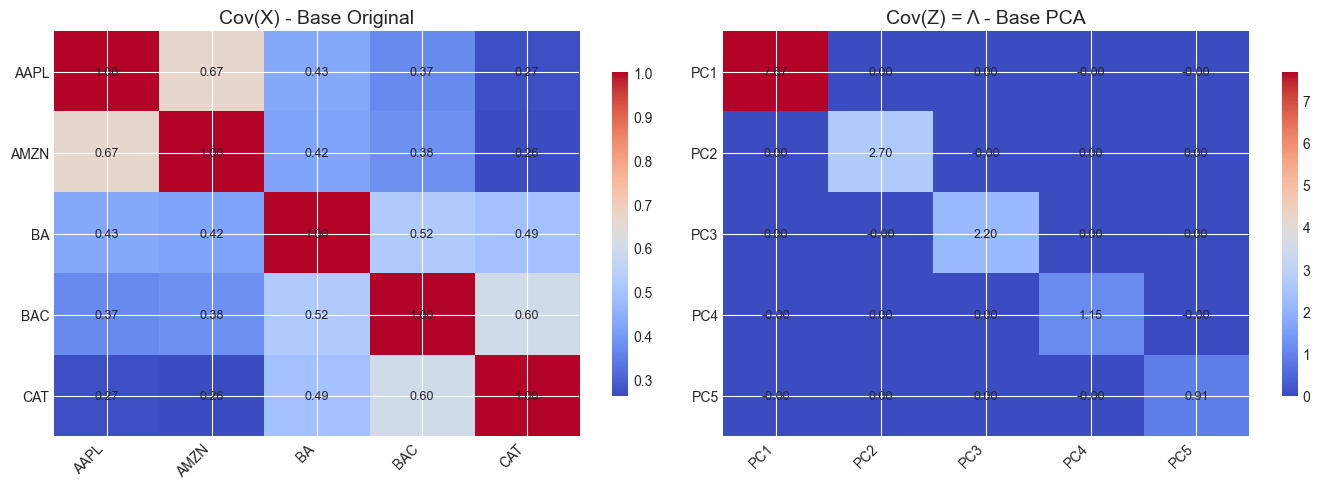

In [43]:
# verificar que PCA realmente diagonaliza la covarianza
# Covarianza original estaria llena de términos cruzados
# Covarianza en la nueva base deberia ser DIAGONAL

pca_returns = pca_result[:, :5]  # Primeros 5 pcs
cov_original = np.cov(returns_scaled.T)
cov_pca = np.cov(pca_returns.T)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# covarianza original[:5]
im1 = axes[0].imshow(cov_original[:5, :5], cmap='coolwarm', aspect='auto')
plt.colorbar(im1, ax=axes[0], shrink=0.8)
for i in range(5):
    for j in range(5):
        axes[0].text(j, i, f'{cov_original[i, j]:.2f}', ha='center', va='center', fontsize=9)
axes[0].set_xticks(range(5))
axes[0].set_xticklabels(log_returns.columns[:5], rotation=45, ha='right')
axes[0].set_yticks(range(5))
axes[0].set_yticklabels(log_returns.columns[:5])
axes[0].set_title('Cov(X) - Base Original')

#covarianza en la base de PCA
im2 = axes[1].imshow(cov_pca, cmap='coolwarm', aspect='auto')
plt.colorbar(im2, ax=axes[1], shrink=0.8)
for i in range(5):
    for j in range(5):
        axes[1].text(j, i, f'{cov_pca[i, j]:.2f}', ha='center', va='center', fontsize=9)
axes[1].set_xticks(range(5))
axes[1].set_xticklabels([f'PC{i+1}' for i in range(5)], rotation=45, ha='right')
axes[1].set_yticks(range(5))
axes[1].set_yticklabels([f'PC{i+1}' for i in range(5)])
axes[1].set_title('Cov(Z) = Λ - Base PCA')

plt.tight_layout()
plt.show()

## No-Estacionariedad: La Base Cambia en el Tiempo

Hasta aquí todo parece limpio y elegante. Pero hay un problema fundamental: **los factores NO son estables en el tiempo**. El "factor de mercado" de 2021 no es el mismo que el de 2022. Los loadings rotan, los eigenvalores cambian, y la estructura de correlación se reestructura continuamente.

Vamos a comprobarlo con PCA rolling, ajustar PCA en ventanas de 60 días y observar cómo cambia la varianza explicada por cada componente.

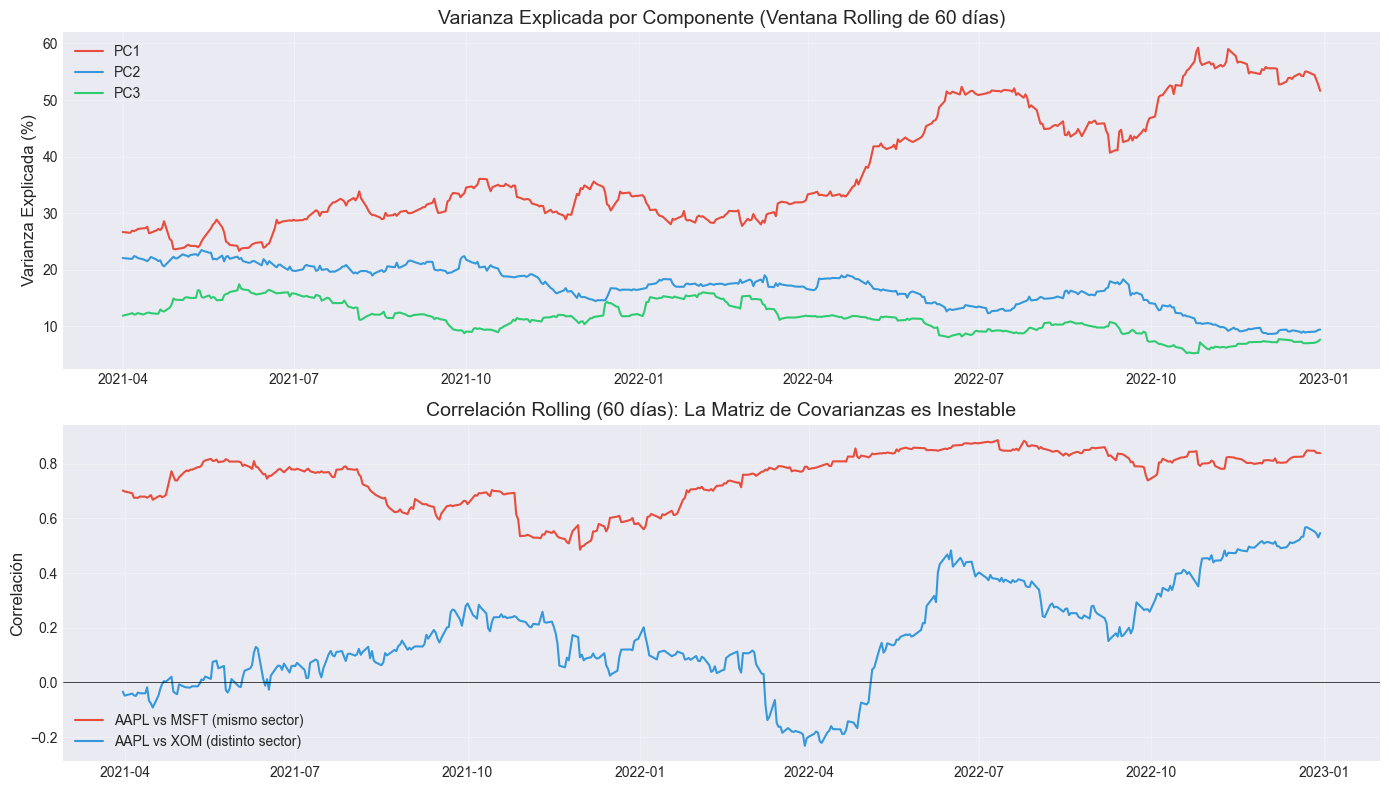

PC1 varía entre 23.3% y 59.3% de varianza explicada
Correlación AAPL-MSFT varía entre 0.49 y 0.89
Correlación AAPL-XOM varía entre  -0.23 y 0.57


In [44]:
# PCA Rolling
window_size = 60
rolling_variance = []
rolling_dates = []

returns_values = log_returns.values

for i in range(window_size, len(returns_values)):
    window = returns_values[i - window_size:i]
    window_scaled = StandardScaler().fit_transform(window)
    pca_window = PCA()
    pca_window.fit(window_scaled)
    rolling_variance.append(pca_window.explained_variance_ratio_[:3])
    rolling_dates.append(log_returns.index[i])

rolling_df = pd.DataFrame(rolling_variance, columns=['PC1', 'PC2', 'PC3'], index=rolling_dates)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
#varianza cambiando
for col, color in zip(['PC1', 'PC2', 'PC3'], ['#e74c3c', '#3498db', '#2ecc71']):axes[0].plot(rolling_df.index, rolling_df[col] * 100, label=col, color=color, linewidth=1.5)
axes[0].set_ylabel('Varianza Explicada (%)')
axes[0].set_title('Varianza Explicada por Componente (Ventana Rolling de 60 días)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# correlacion rolling
rolling_corr_tech = log_returns['AAPL'].rolling(window_size).corr(log_returns['MSFT'])
rolling_corr_cross = log_returns['AAPL'].rolling(window_size).corr(log_returns['XOM'])

axes[1].plot(rolling_corr_tech.index, rolling_corr_tech.values, label='AAPL vs MSFT (mismo sector)',color='#e74c3c', linewidth=1.5)
axes[1].plot(rolling_corr_cross.index, rolling_corr_cross.values, label='AAPL vs XOM (distinto sector)',color='#3498db', linewidth=1.5)
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].set_ylabel('Correlación')
axes[1].set_title('Correlación Rolling (60 días): La Matriz de Covarianzas es Inestable')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PC1 varía entre {rolling_df['PC1'].min()*100:.1f}% y {rolling_df['PC1'].max()*100:.1f}% de varianza explicada")
print(f"Correlación AAPL-MSFT varía entre {rolling_corr_tech.min():.2f} y {rolling_corr_tech.max():.2f}")
print(f"Correlación AAPL-XOM varía entre  {rolling_corr_cross.min():.2f} y {rolling_corr_cross.max():.2f}")

## ¿Por Qué la Optimización de Carteras "No Funciona"?

La optimización clásica de Markowitz busca los pesos $\mathbf{w}^*$ que maximizan el ratio de Sharpe:

$$
\max_{\mathbf{w}} \frac{\mathbf{w}^T \boldsymbol{\mu} - R_f}{\sqrt{\mathbf{w}^T \Sigma \, \mathbf{w}}} \quad \text{sujeto a} \quad \sum w_i = 1, \quad w_i \geq 0
$$

El problema es que **necesitamos estimar $\boldsymbol{\mu}$ y $\Sigma$ de datos históricos**, y como acabamos de ver:
1. $\Sigma$ **cambia en el tiempo** (no-estacionariedad)
2. $\boldsymbol{\mu}$ es **extremadamente ruidoso** (recordemos el notebook 3.2: necesitamos miles de años para estimar $\mu$ con precisión)
3. El optimizador **amplifica los errores de estimación**: busca los pesos que mejor explotan las imprecisiones de nuestra $\hat{\Sigma}$ y $\hat{\boldsymbol{\mu}}$

El resultado es que la cartera "óptima" en datos históricos es lo que en Machine Learning se llama **overfitting**: memoriza el ruido del pasado en lugar de capturar estructura real.

Vamos a demostrarlo con un ejemplo concreto.

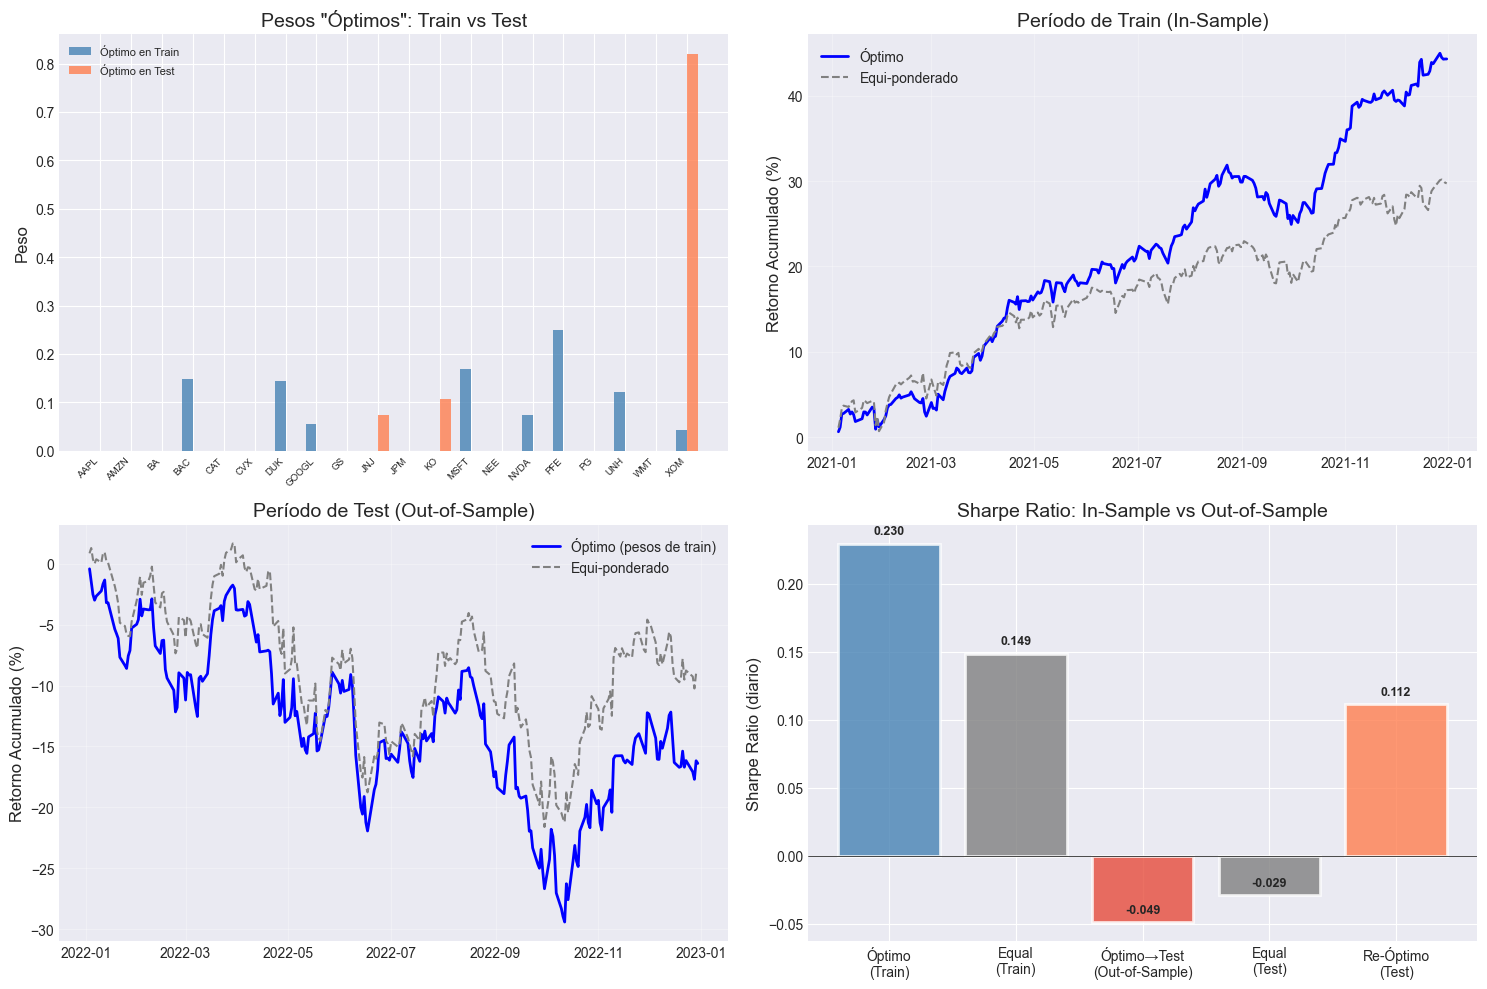

=== RESULTADOS ===
IN-SAMPLE (Train):
  Portfolio Óptimo  → Sharpe: 0.2297
  Equiponderado    → Sharpe: 0.1488
OUT-OF-SAMPLE (Test, con pesos de train):
  Portfolio Óptimo  → Sharpe: -0.0487
  Equi¡ponderado    → Sharpe: -0.0289


In [47]:
# split train test"
split_idx = len(log_returns) // 2
train_returns = log_returns.iloc[:split_idx].values
test_returns = log_returns.iloc[split_idx:].values
train_dates = log_returns.index[:split_idx]
test_dates = log_returns.index[split_idx:]

rf = 0.01 / 252  #risk free daily

def portfolio_metrics(w, returns_data):
    mu = np.mean(returns_data, axis=0)
    cov = np.cov(returns_data.T)
    port_return = w @ mu
    port_vol = np.sqrt(w @ cov @ w)
    sharpe = (port_return - rf) / port_vol if port_vol > 0 else 0
    return port_return, port_vol, sharpe

# Optimizar en TRAIN
n = train_returns.shape[1]
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1)] * n

result = minimize(
    lambda w: -portfolio_metrics(w, train_returns)[2],
    x0=np.ones(n) / n,
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'
)
optimal_weights = result.x
equal_weights = np.ones(n) / n

# Métricas en TRAIN
train_opt_ret, train_opt_vol, train_opt_sharpe = portfolio_metrics(optimal_weights, train_returns)
train_eq_ret, train_eq_vol, train_eq_sharpe = portfolio_metrics(equal_weights, train_returns)

# Métricas en TEST (out-of-sample) con los MISMOS pesos optimizados en train
test_opt_ret, test_opt_vol, test_opt_sharpe = portfolio_metrics(optimal_weights, test_returns)
test_eq_ret, test_eq_vol, test_eq_sharpe = portfolio_metrics(equal_weights, test_returns)

# Re-optimizar en TEST para ver qué "hubiera sido óptimo"
result_test = minimize(
    lambda w: -portfolio_metrics(w, test_returns)[2],
    x0=np.ones(n) / n,
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'
)
reopt_weights = result_test.x
test_reopt_ret, test_reopt_vol, test_reopt_sharpe = portfolio_metrics(reopt_weights, test_returns)

#----
#plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# weights optimnos de train vs test
x_pos = np.arange(n)
width = 0.35
axes[0, 0].bar(x_pos - width/2, optimal_weights, width, label='Óptimo en Train', color='steelblue', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, reopt_weights, width, label='Óptimo en Test', color='coral', alpha=0.8)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(log_returns.columns, rotation=45, ha='right', fontsize=7)
axes[0, 0].set_ylabel('Peso')
axes[0, 0].set_title('Pesos "Óptimos": Train vs Test')
axes[0, 0].legend(fontsize=8)

#evolucion cumsum
train_cum_opt = np.cumsum(train_returns @ optimal_weights) * 100
train_cum_eq = np.cumsum(train_returns @ equal_weights) * 100
test_cum_opt = np.cumsum(test_returns @ optimal_weights) * 100
test_cum_eq = np.cumsum(test_returns @ equal_weights) * 100

axes[0, 1].plot(train_dates, train_cum_opt, 'b-', linewidth=2, label='Óptimo')
axes[0, 1].plot(train_dates, train_cum_eq, 'gray', linewidth=1.5, linestyle='--', label='Equi-ponderado')
axes[0, 1].set_title('Período de Train (In-Sample)')
axes[0, 1].set_ylabel('Retorno Acumulado (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(test_dates, test_cum_opt, 'b-', linewidth=2, label='Óptimo (pesos de train)')
axes[1, 0].plot(test_dates, test_cum_eq, 'gray', linewidth=1.5, linestyle='--', label='Equi-ponderado')
axes[1, 0].set_title('Período de Test (Out-of-Sample)')
axes[1, 0].set_ylabel('Retorno Acumulado (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

#comparacion sharpes
labels = ['Óptimo\n(Train)', 'Equal\n(Train)', 'Óptimo→Test\n(Out-of-Sample)', 'Equal\n(Test)', 'Re-Óptimo\n(Test)']
sharpes = [train_opt_sharpe, train_eq_sharpe, test_opt_sharpe, test_eq_sharpe, test_reopt_sharpe]
bar_colors = ['steelblue', 'gray', '#e74c3c', 'gray', 'coral']
axes[1, 1].bar(labels, sharpes, color=bar_colors, alpha=0.8, edgecolor='white', linewidth=2)
axes[1, 1].set_ylabel('Sharpe Ratio (diario)')
axes[1, 1].set_title('Sharpe Ratio: In-Sample vs Out-of-Sample')
axes[1, 1].axhline(y=0, color='black', linewidth=0.5)

for i, v in enumerate(sharpes):
    axes[1, 1].text(i, v + max(sharpes)*0.03, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("=== RESULTADOS ===")
print(f"IN-SAMPLE (Train):")
print(f"  Portfolio Óptimo  → Sharpe: {train_opt_sharpe:.4f}")
print(f"  Equiponderado    → Sharpe: {train_eq_sharpe:.4f}")
print(f"OUT-OF-SAMPLE (Test, con pesos de train):")
print(f"  Portfolio Óptimo  → Sharpe: {test_opt_sharpe:.4f}")
print(f"  Equi¡ponderado    → Sharpe: {test_eq_sharpe:.4f}")

Los pesos óptimos son completamente **diferentes** entre el periodo de train y test. Esto demuestra que la optimización está capturando **ruido** específico de cada periodo, no estructura persistente.

El optimizador de Markowitz actúa como una red neuronal overfitteada: memoriza los patrones del dataset de entrenamiento (la $\hat{\Sigma}$ y $\hat{\boldsymbol{\mu}}$ históricas), y cuando la distribución cambia, cosa que pasa siempre en mercados, el rendimiento se degrada.

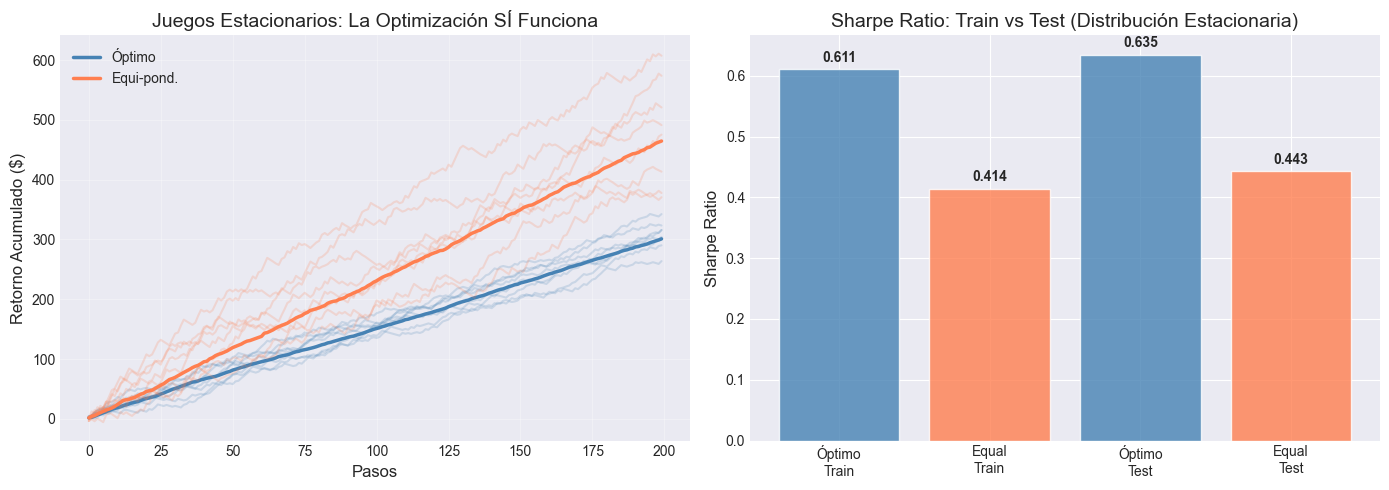

Pesos óptimos: Juego1=0.85, Juego2=0.00, Juego3=0.15

Sharpe Train: 0.611  |  Sharpe Test: 0.635

→ Cuando la distribución es ESTACIONARIA, los pesos óptimos se transfieren perfectamente.
→ El problema no es la optimización en sí, sino que en mercados reales Σ y μ cambian.


In [34]:
# juegos estacionarios donde la optimización SÍ funciona

def play_all_games(weights=[1.0, 1.0, 1.0]):
    """tres juegos con parámetros FIJOS (estacionarios) y correlación via dado compartido"""
    dice_roll = np.random.randint(1, 7)
    extra_dice = np.random.randint(1, 7, size=2)
    
    # Juego 1: Resultado depende del dado
    if dice_roll >= 4:
        g1 = (2 + dice_roll/6) * weights[0]
    else:
        g1 = (-1 + dice_roll/12) * weights[0]
    
    # Juego 2: Doble o nada (mismo dado)
    g2 = 15 * weights[1] if dice_roll >= 5 else -5 * weights[1]
    
    # Juego 3: Suma de tres dados
    total = dice_roll + np.sum(extra_dice)
    g3 = total * weights[2] if total > 10 else -total/2 * weights[2]
    
    return g1, g2, g3

n_trials = 10000
results_train = np.array([play_all_games() for _ in range(n_trials)])
#opt en train
def neg_sharpe_games(w):
    port = results_train @ w
    return -np.mean(port) / np.std(port) if np.std(port) > 0 else 0

res = minimize(neg_sharpe_games, x0=[1/3, 1/3, 1/3],
               bounds=[(0, 1)]*3, constraints={'type': 'eq', 'fun': lambda w: sum(w) - 1})
opt_w_games = res.x
#test pero ahora es igual distrib
results_test = np.array([play_all_games() for _ in range(n_trials)])

#comparison
train_port = results_train @ opt_w_games
test_port = results_test @ opt_w_games
train_equal = results_train @ [1/3, 1/3, 1/3]
test_equal = results_test @ [1/3, 1/3, 1/3]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Paths acumulados
n_paths = 8
n_steps = 200
for name, w, color in [('Óptimo', opt_w_games, 'steelblue'), ('Equi-pond.', [1/3,1/3,1/3], 'coral')]:
    for _ in range(n_paths):
        cumulative = np.cumsum([sum(play_all_games(w)) for _ in range(n_steps)])
        axes[0].plot(cumulative, color=color, alpha=0.2)
    # Media
    paths = np.array([np.cumsum([sum(play_all_games(w)) for _ in range(n_steps)]) for _ in range(50)])
    axes[0].plot(np.mean(paths, axis=0), color=color, linewidth=2.5, label=f'{name}')

axes[0].set_xlabel('Pasos')
axes[0].set_ylabel('Retorno Acumulado ($)')
axes[0].set_title('Juegos Estacionarios: La Optimización SÍ Funciona')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sharpe comparison
labels = ['Óptimo\nTrain', 'Equal\nTrain', 'Óptimo\nTest', 'Equal\nTest']
sharpes = [
    np.mean(train_port)/np.std(train_port),
    np.mean(train_equal)/np.std(train_equal),
    np.mean(test_port)/np.std(test_port),
    np.mean(test_equal)/np.std(test_equal)
]
axes[1].bar(labels, sharpes, color=['steelblue', 'coral', 'steelblue', 'coral'], alpha=0.8, edgecolor='white')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Sharpe Ratio: Train vs Test (Distribución Estacionaria)')
for i, v in enumerate(sharpes):
    axes[1].text(i, v + max(sharpes)*0.02, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Pesos óptimos: Juego1={opt_w_games[0]:.2f}, Juego2={opt_w_games[1]:.2f}, Juego3={opt_w_games[2]:.2f}")
print(f"\nSharpe Train: {sharpes[0]:.3f}  |  Sharpe Test: {sharpes[2]:.3f}")
print(f"\n→ Cuando la distribución es ESTACIONARIA, los pesos óptimos se transfieren perfectamente.")
print(f"→ El problema no es la optimización en sí, sino que en mercados reales Σ y μ cambian.")